In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## function to generate masks from the annotated labels


In [ ]:
# import cv2
# import numpy as np
# import os

# def yolo_segmented_to_binary_mask(image_path, annotation_path, output_dir):
#     image = cv2.imread(image_path)
#     if image is None:
#         print(f"Failed to load {image_path}")
#         return

#     img_height, img_width = image.shape[:2]
#     mask = np.zeros((img_height, img_width), dtype=np.uint8)
#     try:
#         with open(annotation_path, 'r') as file:
#             for line in file:
#                 values = line.split()

#                 # Check if there are at least 3 values (class ID + at least one (x, y) pair)
#                 if len(values) < 3 or (len(values) - 1) % 2 != 0:
#                     print(f"Skipping invalid annotation line: {line.strip()}")
#                     continue

#                 # Extract class_id and polygon coordinates
#                 class_id = int(values[0])
#                 coordinates = list(map(float, values[1:]))

#                 # Convert normalized coordinates to absolute pixel values
#                 points = []
#                 for i in range(0, len(coordinates), 2):
#                     x = int(coordinates[i] * img_width)
#                     y = int(coordinates[i + 1] * img_height)
#                     points.append([x, y])

#                 # Convert points to a numpy array
#                 points = np.array(points, dtype=np.int32).reshape((-1, 1, 2))

#                 # Draw and fill the polygon on the binary mask
#                 cv2.fillPoly(mask, [points], 255)  # Fill the polygon with white (255)

#     except FileNotFoundError:
#         print(f"Annotation file not found: {annotation_path}")
#         return

#     base_name = os.path.splitext(os.path.basename(image_path))[0]
#     output_path = os.path.join(output_dir, f"{base_name}_mask.png")
#     cv2.imwrite(output_path, mask)
#     print(f"Saved mask: {output_path}")

# def process_directory(data_dir):
#     image_dir = os.path.join(data_dir, 'images')
#     label_dir = os.path.join(data_dir, 'labels')
#     output_dir = os.path.join(data_dir, 'masks')

#     os.makedirs(output_dir, exist_ok=True)

#     # Iterate over all image files in the directory
#     for image_file in os.listdir(image_dir):
#         if image_file.endswith('.jpg') or image_file.endswith('.png'):
#             image_path = os.path.join(image_dir, image_file)
#             annotation_file = os.path.splitext(image_file)[0] + '.txt'
#             annotation_path = os.path.join(label_dir, annotation_file)

#             # Convert YOLO annotations to binary masks
#             yolo_segmented_to_binary_mask(image_path, annotation_path, output_dir)

# # Process train, val, and test directories
# process_directory('/content/drive/MyDrive/PurdueWork/Pothole Segmentation/train')
# process_directory('/content/drive/MyDrive/PurdueWork/Pothole Segmentation/valid')
# # process_directory('/content/drive/MyDrive/PurdueWork/Pothole Segmentation/test')


## installs

In [ ]:
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-nxgybeu_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-nxgybeu_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=12664291a7c692c2464939bd6a7a56004aa6930de470f440851e3aed80b0c554
  Stored in directory: /tmp/pip-ephem-wheel-cache-he20km9j/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to

In [ ]:
! pip install datasets

In [ ]:
from datasets import Dataset

In [ ]:
import numpy as np
import glob ,os
import cv2
import matplotlib.pyplot as plt
from patchify import patchify
import random
from scipy import ndimage
#from datasets import Dataset
from PIL import Image
import torch
from transformers import SamModel, SamConfig, SamProcessor
from tqdm import tqdm
from statistics import mean
from torch.utils.data import DataLoader
from torchvision import transforms


In [ ]:
# imgfolder='/content/drive/MyDrive/PurdueWork/Pothole Segmentation/train/images'
imgfolder='/content/drive/MyDrive/Pothole Segmentation-2/train/images'
img=sorted(glob.glob(imgfolder+'/*.jpg'))
imgarr=[]
for i in img:
  im=cv2.imread(i)
  imgarr.append(im)
images=np.array(imgarr)
images.shape

(338, 640, 640, 3)

In [ ]:
imgname=os.listdir(imgfolder)
imgname=sorted(imgname)

In [ ]:
# maskfolder='/content/drive/MyDrive/PurdueWork/Pothole Segmentation/train/masks'
maskfolder='/content/drive/MyDrive/Pothole Segmentation-2/train/masks'
mask=sorted(glob.glob(maskfolder+'/*.png'))
maskarr=[]
for i in mask:
  mas=cv2.imread(i)
  maskarr.append(mas)
masks=np.array(maskarr)
masks.shape

(338, 640, 640, 3)

In [ ]:
maskname=os.listdir(maskfolder)
maskname=sorted(maskname)

In [ ]:
masks.shape

(338, 640, 640, 3)

# CREATING DATASET

In [ ]:
data={
    "image":[Image.fromarray(imag) for imag in images],
    "masks":[Image.fromarray(mas) for mas in masks],
}

In [ ]:
dataset = Dataset.from_dict(data)

In [ ]:
dataset

Dataset({
    features: ['image', 'masks'],
    num_rows: 338
})

Checking that images and masks are properly mapped

ImageName: test_029_jpg.rf.aee0ad6a6fee34e695e38b891df161e6.jpg
MaskName: test_029_jpg.rf.aee0ad6a6fee34e695e38b891df161e6_mask.png


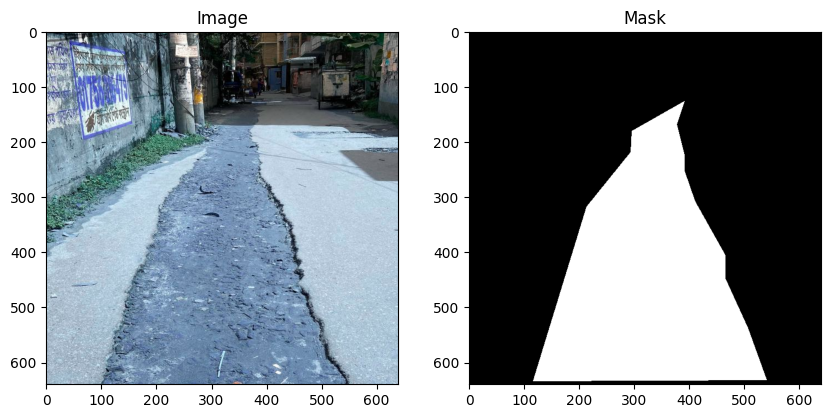

In [ ]:
img_num = random.randint(0, images.shape[0]-1)
testimage = dataset[img_num]["image"]
testmask = dataset[img_num]["masks"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

print(f"ImageName: {imgname[img_num]}")
axes[0].imshow(np.array(testimage))
axes[0].set_title("Image")

print(f"MaskName: {maskname[img_num]}")
axes[1].imshow(testmask, cmap='gray')
axes[1].set_title("Mask")

plt.show()

### boundingbox

In [ ]:


def get_bounding_boxes(mask):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if cv2.contourArea(contour) < 100:
            continue
        padding = np.random.randint(0, 10)
        xmin = max(0, x - padding)
        ymin = max(0, y - padding)
        xmax = min(mask.shape[1], x + w + padding)
        ymax = min(mask.shape[0], y + h + padding)

        bounding_boxes.append([xmin, ymin, xmax, ymax])

    return bounding_boxes

example_mask_array = masks[45]
bounding_boxes = get_bounding_boxes(example_mask_array)
for i, bbox in enumerate(bounding_boxes):
    print(f"Bounding Box {i+1}: {bbox}")


Bounding Box 1: [92, 421, 175, 518]
Bounding Box 2: [399, 402, 544, 639]
Bounding Box 3: [191, 370, 360, 483]
Bounding Box 4: [312, 233, 437, 262]
Bounding Box 5: [361, 226, 640, 386]
Bounding Box 6: [417, 184, 558, 231]
Bounding Box 7: [9, 162, 364, 261]
Bounding Box 8: [600, 105, 640, 148]


In [ ]:
bounding_boxes # format matches with required list of lists

[[92, 421, 175, 518],
 [399, 402, 544, 639],
 [191, 370, 360, 483],
 [312, 233, 437, 262],
 [361, 226, 640, 386],
 [417, 184, 558, 231],
 [9, 162, 364, 261],
 [600, 105, 640, 148]]

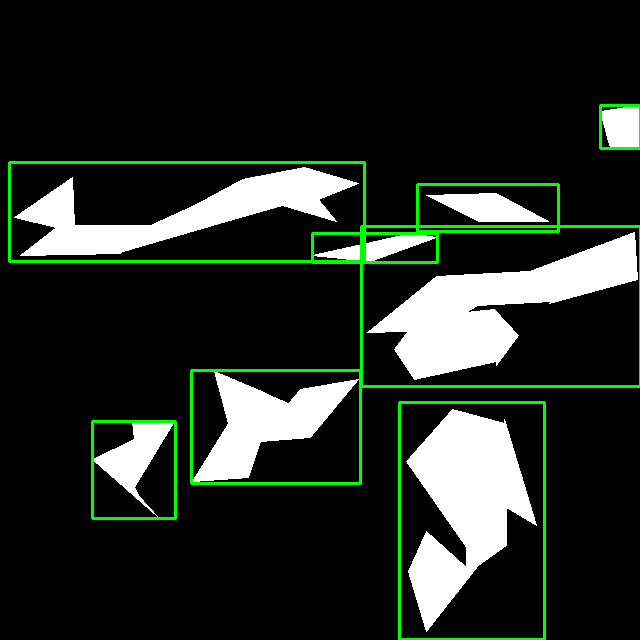

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

example_mask_array = masks[45]
if len(example_mask_array.shape) == 2:
    mask_with_boxes = cv2.cvtColor(example_mask_array, cv2.COLOR_GRAY2BGR)
else:
    mask_with_boxes = example_mask_array.copy()

for bbox in bounding_boxes:
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(mask_with_boxes, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

cv2_imshow(mask_with_boxes)

## dataset preparation

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["masks"])

    prompt = get_bounding_boxes(ground_truth_mask)

    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# Create a DataLoader instance for the training dataset

In [ ]:
def custom_collate_fn(batch):
    imgs = [transforms.ToPILImage()(item['pixel_values']) for item in batch]
    masks = [transforms.ToPILImage()(item['ground_truth_mask']) for item in batch]
    input_boxes = [item['input_boxes'] for item in batch]
    max_size_img = max(img.size for img in imgs)
    max_size_mask = max(mask.size for mask in masks)

    padded_imgs = []
    padded_masks = []
    for img, mask in zip(imgs, masks):
        pad_width = (0, max_size_img[0] - img.size[0], 0, max_size_img[1] - img.size[1])
        padded_img = transforms.functional.pad(img, pad_width, fill=0)
        padded_imgs.append(padded_img)

        pad_width = (0, max_size_mask[0] - mask.size[0], 0, max_size_mask[1] - mask.size[1])
        padded_mask = transforms.functional.pad(mask, pad_width, fill=0)
        padded_masks.append(padded_mask)

    padded_imgs_tensor = torch.stack([transforms.ToTensor()(img) for img in padded_imgs])
    padded_masks_tensor = torch.stack([transforms.ToTensor()(mask) for mask in padded_masks])

    batch_dict = []
    for i in range(len(batch)):
        item_dict = {
            'pixel_values': padded_imgs_tensor[i],
            'ground_truth_mask': padded_masks_tensor[i],
            'input_boxes': input_boxes[i]
        }
        batch_dict.append(item_dict)

    return batch_dict

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False, collate_fn=custom_collate_fn)
batch = next(iter(train_dataloader))

for item in batch:
    for k, v in item.items():
        print(k, v.shape)


pixel_values torch.Size([3, 1024, 1024])
ground_truth_mask torch.Size([3, 640, 640])
input_boxes torch.Size([5, 4])
pixel_values torch.Size([3, 1024, 1024])
ground_truth_mask torch.Size([3, 640, 640])
input_boxes torch.Size([25, 4])


In [ ]:
def custom_collate_fn(batch):
    pixel_values_list = []
    ground_truth_mask_list = []

    for item in batch:
        pixel_values_list.append(transforms.ToPILImage()(item['pixel_values']))
        ground_truth_mask_list.append(transforms.ToPILImage()(item['ground_truth_mask']))

    max_size_img = max(img.size for img in pixel_values_list)
    max_size_mask = max(mask.size for mask in ground_truth_mask_list)

    padded_pixel_values = []
    padded_ground_truth_masks = []
    for img, mask in zip(pixel_values_list, ground_truth_mask_list):
        pad_width = (0, max_size_img[0] - img.size[0], 0, max_size_img[1] - img.size[1])
        padded_pixel_values.append(transforms.functional.pad(img, pad_width, fill=0))

        pad_width = (0, max_size_mask[0] - mask.size[0], 0, max_size_mask[1] - mask.size[1])
        padded_ground_truth_masks.append(transforms.functional.pad(mask, pad_width, fill=0))

    return {
        "pixel_values": torch.stack([transforms.ToTensor()(img) for img in padded_pixel_values]),
        "original_sizes": torch.tensor([img.size for img in pixel_values_list]),
        "reshaped_input_sizes": torch.tensor([img.size for img in padded_pixel_values]),
        "input_boxes": torch.zeros(len(batch), 1, 4),
        "ground_truth_mask": torch.stack([transforms.ToTensor()(mask) for mask in padded_ground_truth_masks])
    }

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False, collate_fn=custom_collate_fn)


In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 3, 640, 640])


In [ ]:

from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')


# TRAINING 50 *EPOCHS*

In [ ]:

num_epochs = 50

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        batch_loss = []
        for i in range(len(batch["ground_truth_mask"])):
            predicted_masks = outputs.pred_masks[i].squeeze(0)
            ground_truth_masks = batch["ground_truth_mask"][i][:1].float().to(device)

            ground_truth_masks_resized = torch.nn.functional.interpolate(
                ground_truth_masks.unsqueeze(0),
                size=predicted_masks.shape[-2:],
                mode='bilinear',
                align_corners=False
            ).squeeze(0)

            loss = seg_loss(predicted_masks, ground_truth_masks_resized)
            batch_loss.append(loss)

        mean_loss = torch.mean(torch.stack(batch_loss))

        optimizer.zero_grad()
        mean_loss.backward()

        optimizer.step()
        epoch_losses.append(mean_loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 169/169 [03:29<00:00,  1.24s/it]


EPOCH: 0
Mean loss: 233.44709999039327


100%|██████████| 169/169 [03:22<00:00,  1.20s/it]


EPOCH: 1
Mean loss: 231.62119767087452


100%|██████████| 169/169 [03:23<00:00,  1.20s/it]


EPOCH: 2
Mean loss: 230.62354940493432


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 3
Mean loss: 229.21901362041044


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 4
Mean loss: 227.93600854365783


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 5
Mean loss: 226.8865376590977


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 6
Mean loss: 225.84800820661013


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 7
Mean loss: 225.3013854732175


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 8
Mean loss: 223.5636918058057


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 9
Mean loss: 222.57233322513173


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 10
Mean loss: 221.5000025929784


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 11
Mean loss: 220.79914131390274


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 12
Mean loss: 221.14771259465866


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 13
Mean loss: 220.27300402398646


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 14
Mean loss: 219.92782670647435


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 15
Mean loss: 219.6341836918035


100%|██████████| 169/169 [03:21<00:00,  1.20s/it]


EPOCH: 16
Mean loss: 218.84561141426042


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 17
Mean loss: 217.95252047205818


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 18
Mean loss: 217.42394742316748


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 19
Mean loss: 217.16165522287582


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 20
Mean loss: 216.80190331554977


100%|██████████| 169/169 [03:23<00:00,  1.21s/it]


EPOCH: 21
Mean loss: 216.26735752256664


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 22
Mean loss: 216.02704573524068


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 23
Mean loss: 216.1888013760719


100%|██████████| 169/169 [03:22<00:00,  1.20s/it]


EPOCH: 24
Mean loss: 215.91362138330584


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 25
Mean loss: 215.74800223852756


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 26
Mean loss: 215.69984423056155


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 27
Mean loss: 215.5778258002016


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 28
Mean loss: 214.91584807175857


100%|██████████| 169/169 [03:22<00:00,  1.20s/it]


EPOCH: 29
Mean loss: 214.63807788932112


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 30
Mean loss: 215.63256550963814


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 31
Mean loss: 214.690758812357


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 32
Mean loss: 213.88113224717992


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 33
Mean loss: 213.57070441253086


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 34
Mean loss: 213.25948375780908


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 35
Mean loss: 213.13766300043412


100%|██████████| 169/169 [03:21<00:00,  1.20s/it]


EPOCH: 36
Mean loss: 212.96856311369226


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 37
Mean loss: 213.2489313737175


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 38
Mean loss: 212.4393476621639


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 39
Mean loss: 212.11344593657543


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 40
Mean loss: 212.01400347715298


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 41
Mean loss: 212.214218861958


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 42
Mean loss: 213.19804213315072


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 43
Mean loss: 212.6219281303812


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 44
Mean loss: 211.8350259820385


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 45
Mean loss: 211.52524498193222


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 46
Mean loss: 211.12301046044163


100%|██████████| 169/169 [03:22<00:00,  1.20s/it]


EPOCH: 47
Mean loss: 211.03183991880812


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]


EPOCH: 48
Mean loss: 211.09898573407054


100%|██████████| 169/169 [03:21<00:00,  1.19s/it]

EPOCH: 49
Mean loss: 211.30043157317934


In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/Pothole Segmentation-2/50epochs_checkpoin.pth")

# 20epochs

In [ ]:

num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        batch_loss = []
        for i in range(len(batch["ground_truth_mask"])):
            predicted_masks = outputs.pred_masks[i].squeeze(0)
            ground_truth_masks = batch["ground_truth_mask"][i][:1].float().to(device)

            ground_truth_masks_resized = torch.nn.functional.interpolate(
                ground_truth_masks.unsqueeze(0),
                size=predicted_masks.shape[-2:],
                mode='bilinear',
                align_corners=False
            ).squeeze(0)

            loss = seg_loss(predicted_masks, ground_truth_masks_resized)
            batch_loss.append(loss)

        mean_loss = torch.mean(torch.stack(batch_loss))

        optimizer.zero_grad()
        mean_loss.backward()

        optimizer.step()
        epoch_losses.append(mean_loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


100%|██████████| 169/169 [02:57<00:00,  1.05s/it]


EPOCH: 0
Mean loss: 241.1564092353956


100%|██████████| 169/169 [03:06<00:00,  1.10s/it]


EPOCH: 1
Mean loss: 234.91738606627877


100%|██████████| 169/169 [03:03<00:00,  1.08s/it]


EPOCH: 2
Mean loss: 232.08269790220544


100%|██████████| 169/169 [03:03<00:00,  1.09s/it]


EPOCH: 3
Mean loss: 230.7568040543054


100%|██████████| 169/169 [03:03<00:00,  1.08s/it]

EPOCH: 4
Mean loss: 228.99799265664004


226


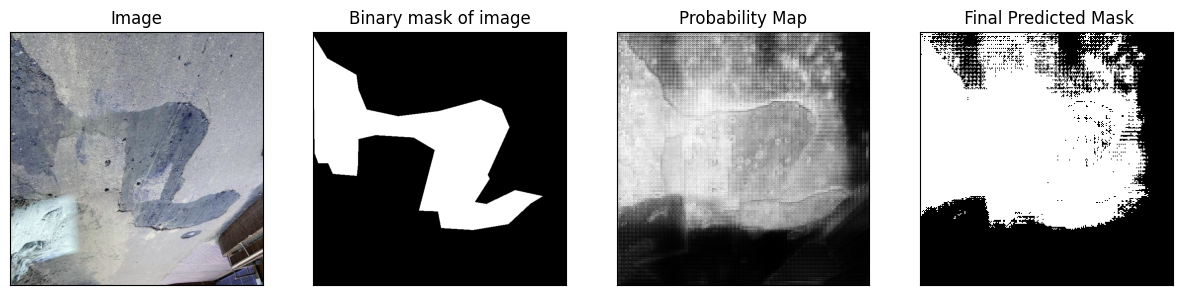

In [ ]:

idx = random.randint(0, images.shape[0] - 1)
print (idx)
test_image = dataset[idx]["image"]
true_mask = dataset[idx]["masks"]

# Getting the box prompt on the ground truth
ground_truth_mask = np.array(dataset[idx]["masks"])
prompt = get_bounding_boxes(ground_truth_mask)

inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=True)

# sigmoid
prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# Convert soft mask to hard mask
prob = prob.cpu().numpy().squeeze()
seg = (prob > 0.5).astype(np.uint8)

# Ensure seg is a 2D grayscale image
if seg.ndim == 3 and seg.shape[0] == 1:
    seg = np.squeeze(seg, axis=0)  # Squeeze the first dimension

prob_selected = prob[0]  # Selecting the first probability map
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# true train image
axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Image")

# Final Predicted Mask
axes[3].imshow(seg[0], cmap='gray')
axes[3].set_title(" Final Predicted Mask")

# Probability Map
axes[2].imshow(prob_selected, cmap='gray')
axes[2].set_title("Probability Map")

# Binary mask of image
axes[1].imshow(true_mask, cmap='jet')
axes[1].set_title("Binary mask of image")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()


In [ ]:
print("Shape of outputs.pred_masks:", outputs.pred_masks.shape) # 3 STANDS FOR CHANNELS


Shape of outputs.pred_masks: torch.Size([1, 2, 3, 256, 256])


In [ ]:
print("Shape of outputs.pred_masks:", outputs.pred_masks.shape)

Shape of outputs.pred_masks: torch.Size([1, 21, 3, 256, 256])


109


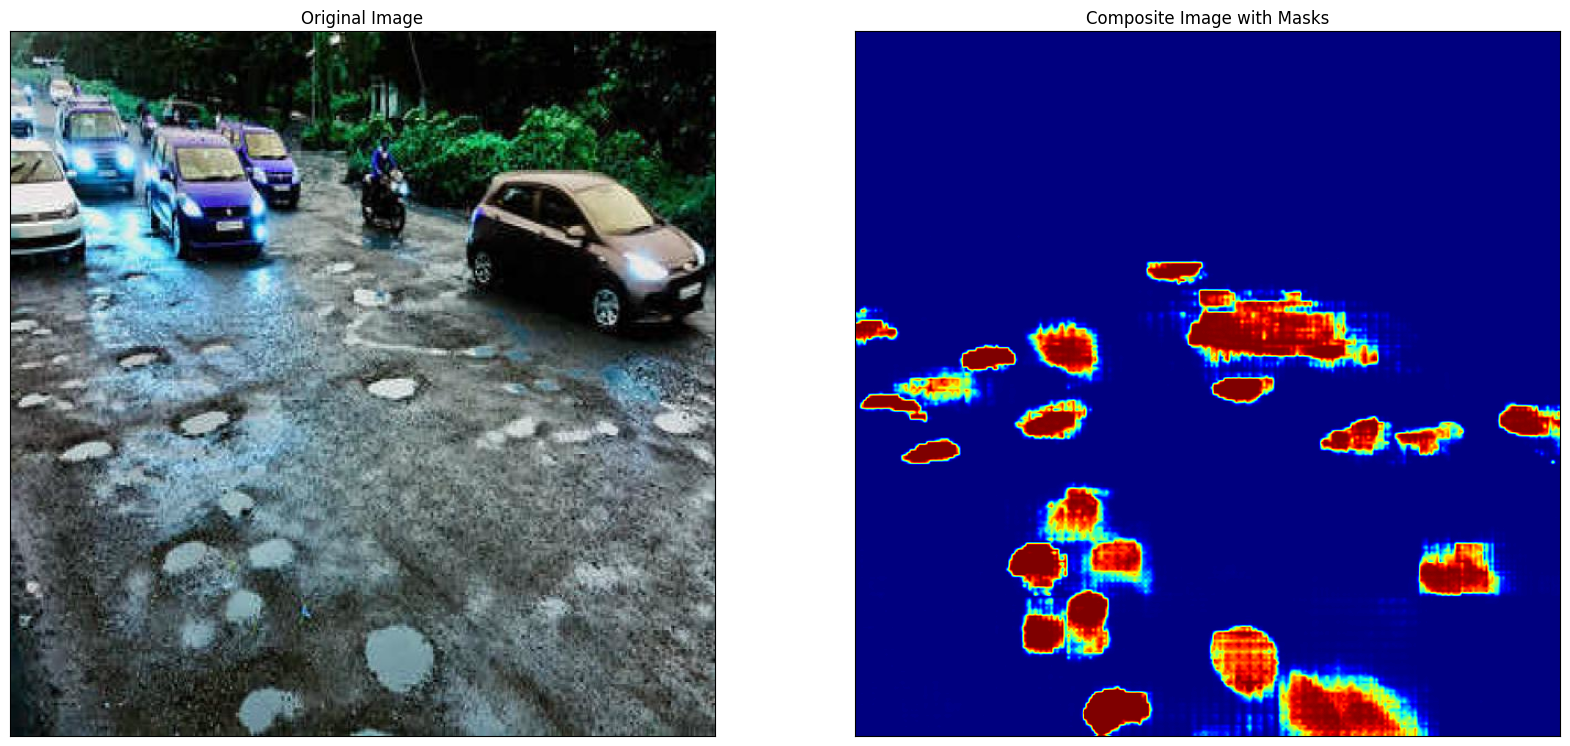

In [ ]:

from skimage.transform import resize

idx = random.randint(0, len(dataset) - 1)
idx = 109
print(idx)
test_image = dataset[idx]["image"]
true_mask = dataset[idx]["masks"]

#  box prompt on the ground truth
ground_truth_mask = np.array(dataset[idx]["masks"])
prompt = get_bounding_boxes(ground_truth_mask)


inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs, multimask_output=True)

#sigmoid
prob = torch.sigmoid(outputs.pred_masks)  # Shape: [batch_size, num_instances, channels, height, width]
prob = prob.squeeze(0).cpu().numpy()  # Remove batch dimension and convert to numpy array

#  number of instances in an iamage
num_instances = prob.shape[0]

# Resize masks to match the dimensions of the original image
original_height, original_width = np.array(test_image).shape[:2]
resized_masks = []
for i in range(num_instances):
    mask_instance = prob[i, 0]  # Select the first channel for each mask instance
    # Resize masks
    resized_mask = resize(mask_instance, (original_height, original_width), mode='reflect', preserve_range=True)
    resized_masks.append(resized_mask)

# Create a composite image
composite_image = np.zeros((original_height, original_width))

for resized_mask in resized_masks:
    # Normalize masks
    resized_mask = resized_mask / resized_mask.max() if resized_mask.max() != 0 else resized_mask
    # Superimpose masks
    composite_image = np.clip(composite_image + resized_mask, 0, 1)


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(composite_image, cmap='jet')
axes[1].set_title("Composite Image with Masks")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()


#Vis *50* eps

In [ ]:
#Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
fabricmodel = SamModel(config=model_config)
# i used this earlier for visualising 20 epochs
# fabricmodel.load_state_dict(torch.load("/content/drive/MyDrive/Pothole Segmentation-2/20epochs_checkpoin.pth"))

## 50 epochs ##

#for gpu
# fabricmodel.load_state_dict(torch.load("/content/drive/MyDrive/PurdueWork/Pothole Segmentation/50epochs_checkpoin.pth"))
#for cpu
fabricmodel.load_state_dict(torch.load("/content/drive/MyDrive/PurdueWork/Pothole Segmentation/50epochs_checkpoin.pth",map_location=torch.device('cpu')))

<ipython-input-59-2f679384986e>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fabricmodel.load_state_dict(torch.load("/content/drive/MyDrive/PurdueWork/Pothole Segmentat

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
fabricmodel.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

109


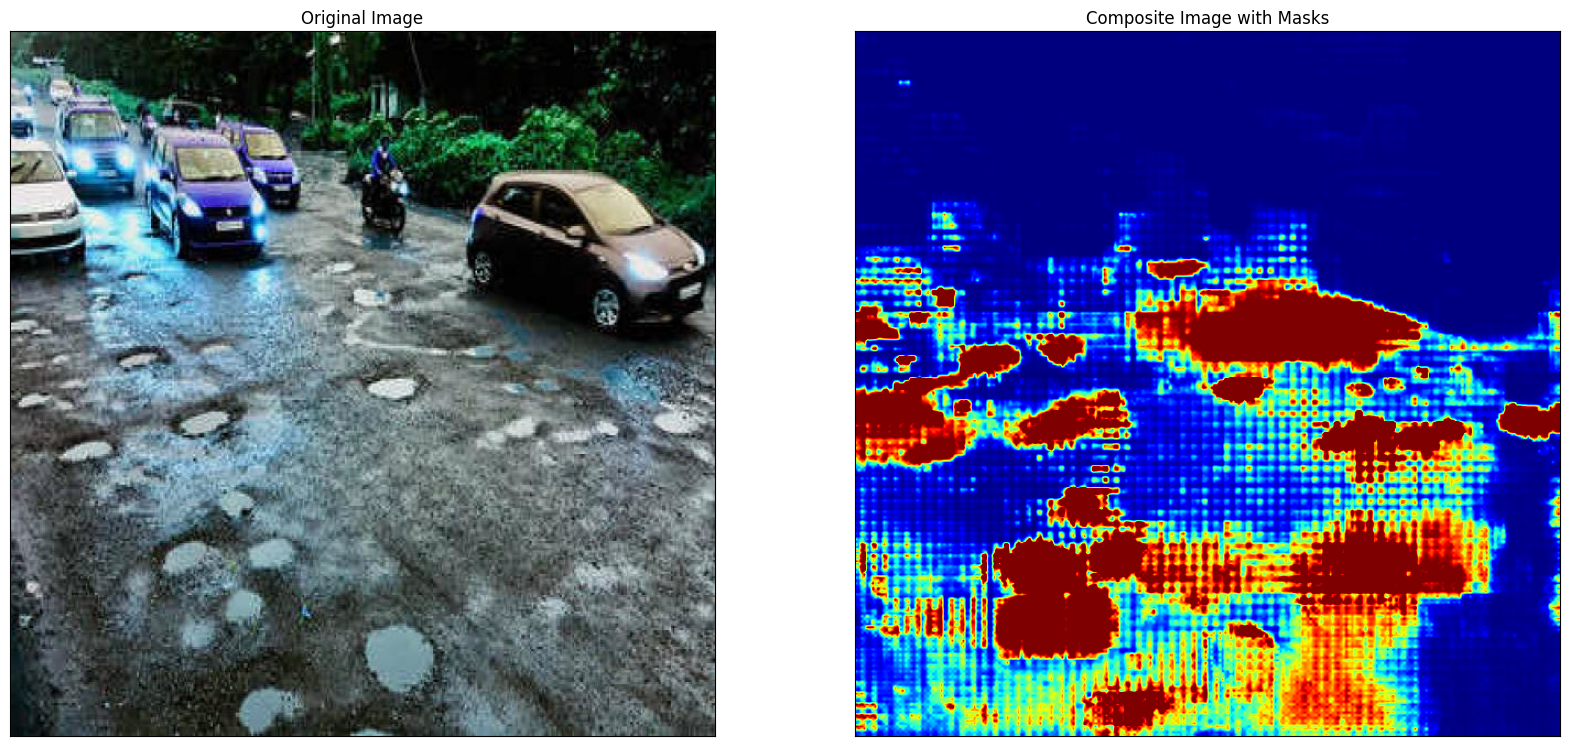

In [ ]:

from skimage.transform import resize

idx = random.randint(0, len(dataset) - 1)
idx = 109
print(idx)

test_image = dataset[idx]["image"]
true_mask = dataset[idx]["masks"]

# prompt based on the ground truth-training
ground_truth_mask = np.array(dataset[idx]["masks"])
prompt = get_bounding_boxes(ground_truth_mask)


inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

fabricmodel.eval()
with torch.no_grad():
    outputs = fabricmodel(**inputs, multimask_output=True)

# sigmoid to get probabilities
prob = torch.sigmoid(outputs.pred_masks)
prob = prob.squeeze(0).cpu().numpy()  # Remove batch dimensions

# number of instances
num_instances = prob.shape[0]

# Resize masks to match the dimensions of the original image
original_height, original_width = np.array(test_image).shape[:2]
resized_masks = []
for i in range(num_instances):
    mask_instance = prob[i, 0]
    # Resize mask
    resized_mask = resize(mask_instance, (original_height, original_width), mode='reflect', preserve_range=True)
    resized_masks.append(resized_mask)

# Create a composite image
composite_image = np.zeros((original_height, original_width))

for resized_mask in resized_masks:
    # Normalize mask
    resized_mask = resized_mask / resized_mask.max() if resized_mask.max() != 0 else resized_mask
    # Superimpose masks
    composite_image = np.clip(composite_image + resized_mask, 0, 1)


fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(composite_image, cmap='jet')
axes[1].set_title("Composite Image with Masks")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()


In [ ]:
print(outputs.keys())



odict_keys(['iou_scores', 'pred_masks'])


Threshold: 0.3


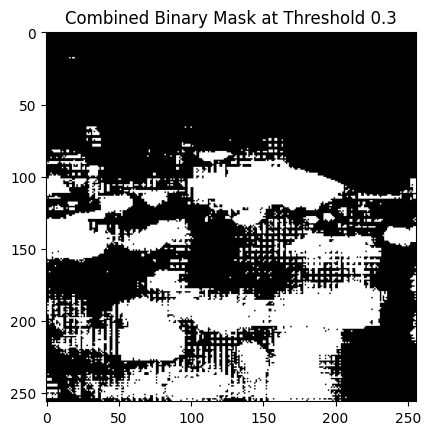

Threshold: 0.5


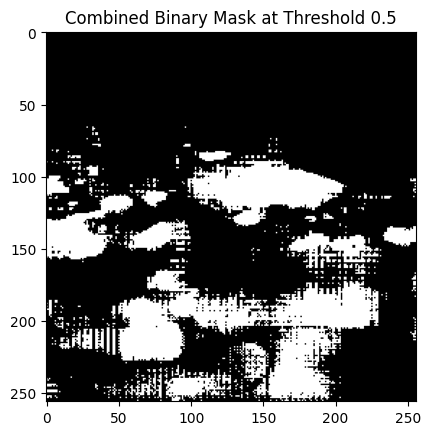

Threshold: 0.7


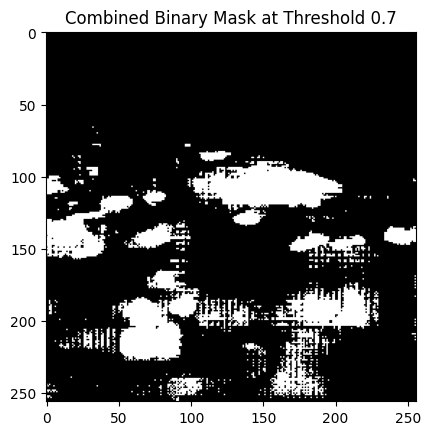

Threshold: 0.9


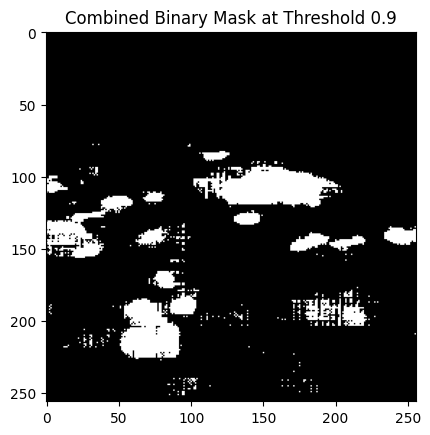

In [ ]:
thresholds = [0.3, 0.5, 0.7,0.9]  # Test with multiple thresholds
for thresh in thresholds:
    binary_masks = (prob > thresh).astype(np.uint8)
    print(f"Threshold: {thresh}")

    combined_mask = np.zeros_like(binary_masks[0, 0], dtype=np.uint8)  # Assuming first channel

    for i, mask in enumerate(binary_masks):
        mask_2d = mask[0]  # Select the first channel for visualization
# Combine the binary masks by using a logical OR
        combined_mask = np.logical_or(combined_mask, mask_2d).astype(np.uint8)

    # Plot the combined binary mask
    plt.imshow(combined_mask, cmap='gray')
    plt.title(f"Combined Binary Mask at Threshold {thresh}")
    plt.show()


109


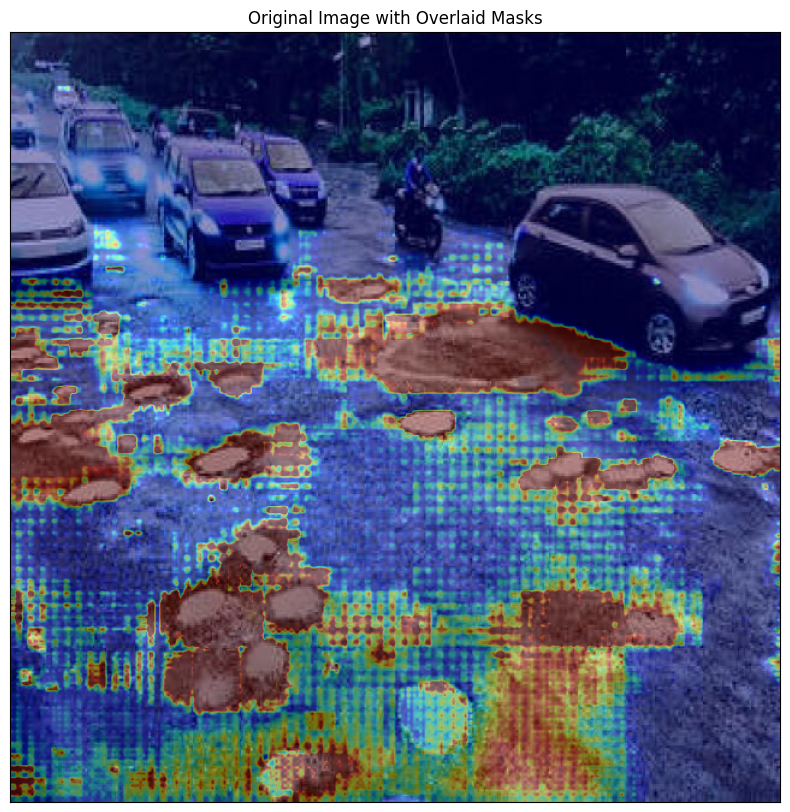

In [ ]:
# sigmoid
prob = torch.sigmoid(outputs.pred_masks)
prob = prob.squeeze(0).cpu().numpy()
num_instances = prob.shape[0]

# Resize masks to match the dimensions of the original image
original_height, original_width = np.array(test_image).shape[:2]
resized_masks = []
for i in range(num_instances):
    mask_instance = prob[i, 0]
    # Resize masks
    resized_mask = resize(mask_instance, (original_height, original_width), mode='reflect', preserve_range=True)
    resized_masks.append(resized_mask)

# Create a composite image
composite_image = np.zeros((original_height, original_width))

for resized_mask in resized_masks:
    # Normalize mask
    resized_mask = resized_mask / resized_mask.max() if resized_mask.max() != 0 else resized_mask
    # Superimpose masks
    composite_image = np.clip(composite_image + resized_mask, 0, 1)

# Plot the original image and overlay the composite image with reduced opacity
fig, ax = plt.subplots(figsize=(10, 10))

# Display the original image
ax.imshow(np.array(test_image), cmap='gray')

# Overlay the composite image (generated masks) with reduced opacity (alpha)
ax.imshow(composite_image, cmap='jet', alpha=0.4)  # Adjust alpha for transparency

# Set title
ax.set_title("Original Image with Overlaid Masks")

# Hide axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Display the image
plt.show()


# INFERENCE on test images and videos


In [ ]:
# image_path='/content/drive/MyDrive/PurdueWork/Pothole Segmentation/valid/images/212_jpg.rf.3c947882e9e89e94a81bdb4863e23d51.jpg'
image_path='/content/drive/MyDrive/Pothole Segmentation-2/valid/images/212_jpg.rf.3c947882e9e89e94a81bdb4863e23d51.jpg'

In [ ]:

from transformers import SamConfig, SamProcessor, SamModel

model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# model architecture
my_mito_model = SamModel(config=model_config)

# model weights
# my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/PurdueWork/Pothole Segmentation/50epochs_checkpoin.pth", weights_only=True,map_location=torch.device('cpu')))
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/Pothole Segmentation-2/50epochs_checkpoin.pth", weights_only=True))
my_mito_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_mito_model.to(device)



SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

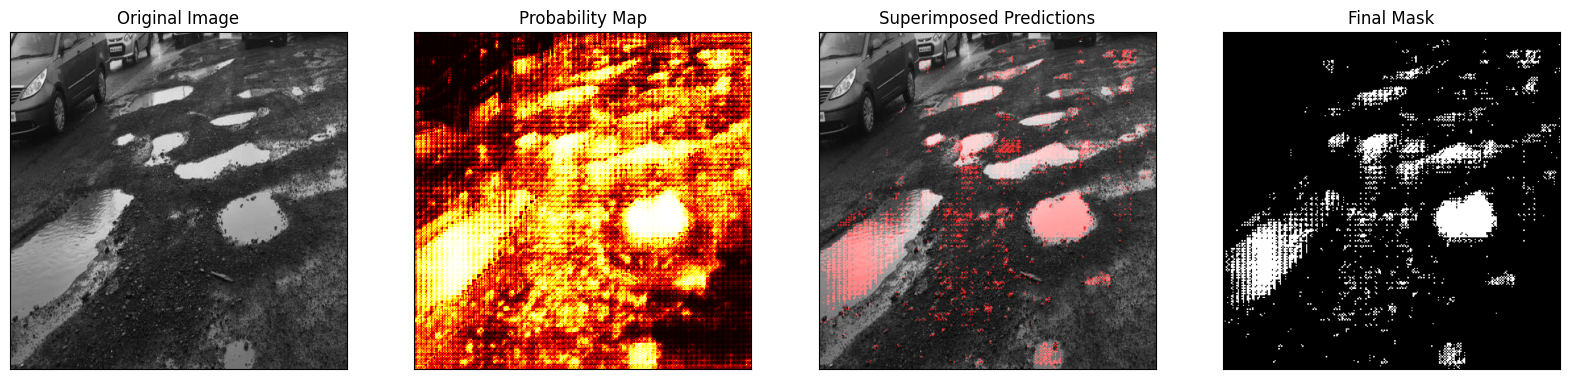

In [ ]:
# Convert grayscale image to RGB
large_test_image_rgb = cv2.cvtColor(large_test_image, cv2.COLOR_GRAY2RGB)
# image to PIL format for processing
single_image = Image.fromarray(large_test_image_rgb)


array_size = large_test_image_rgb.shape[0]
grid_size = 10

# these are basically points that serve as prompts
x = np.linspace(0, array_size - 1, grid_size)
y = np.linspace(0, array_size - 1, grid_size)
xv, yv = np.meshgrid(x, y)
xv_list = xv.tolist()
yv_list = yv.tolist()
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

# Reshape to the expected shape of the input_points tensor
input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2)
# image and prompt for the model
inputs = processor(single_image, input_points=input_points, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}


with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)
prob_masks = torch.sigmoid(outputs.pred_masks.squeeze(1))
prob_masks = prob_masks.cpu().numpy().squeeze()

# Convert soft masks to hard masks after experimenting with a lot of thresholds 0.9 chosen
pred_masks = (prob_masks > 0.9).astype(np.uint8)
pred_masks_resized = cv2.resize(pred_masks, (large_test_image_rgb.shape[1], large_test_image_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

# Superimpose  predicted masks on original image
overlay = np.zeros_like(large_test_image_rgb, dtype=np.float32)
overlay[pred_masks_resized > 0] = [1, 0, 0]
alpha = 0.7  # Opacity

# Blend the original image and the overlay
superimposed_image = np.clip(large_test_image_rgb / 255.0 + alpha * overlay, 0, 1)


fig, axes = plt.subplots(1, 4, figsize=(20, 5))
#original image
axes[0].imshow(large_test_image_rgb)
axes[0].set_title("Original Image")
#probability maps
axes[1].imshow(prob_masks, cmap='hot')
axes[1].set_title("Probability Map")
#superimposed image
axes[2].imshow(superimposed_image)
axes[2].set_title("Superimposed Predictions")
#final mask
axes[3].imshow(pred_masks_resized, cmap='gray')
axes[3].set_title("Final Mask")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()


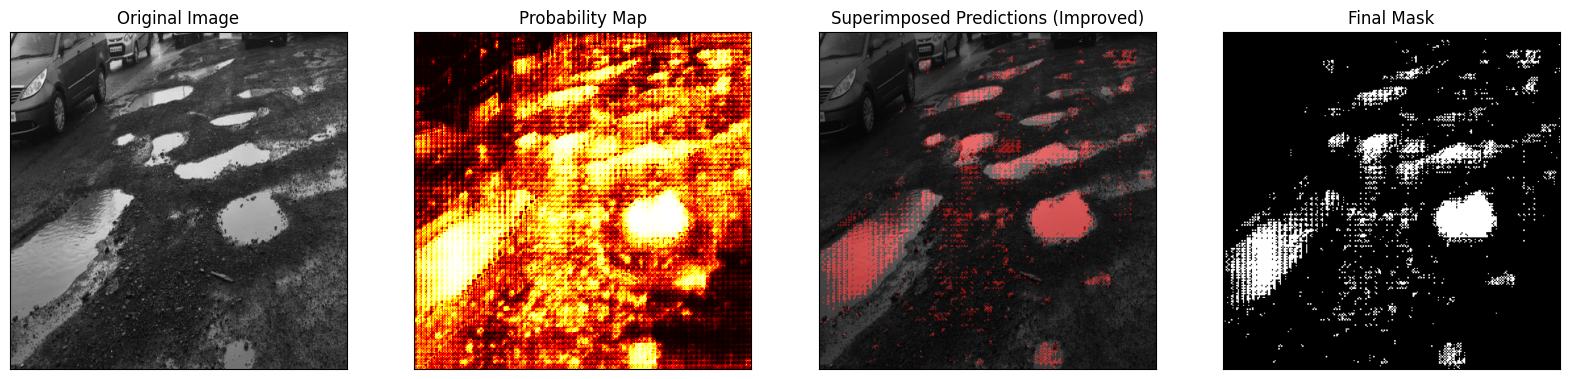

In [ ]:
# Convert the original image to float32 and normalize
original_float = large_test_image_rgb.astype(np.float32) / 255.0

# Create a mask overlay (use red only in the areas where pred_masks_resized == 1)
overlay = np.zeros_like(original_float)
overlay[pred_masks_resized > 0] = [1, 0, 0]

# Use cv2.addWeighted to blend the original image with the overlay
alpha = 0.5  # Opacity
superimposed_image = cv2.addWeighted(original_float, 1 - alpha, overlay, alpha, 0)

# Clip values to [0, 1] in case of overflows and then convert back to 8-bit image for plotting
superimposed_image = np.clip(superimposed_image * 255, 0, 255).astype(np.uint8)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

#  original image
axes[0].imshow(large_test_image_rgb)
axes[0].set_title("Original Image")

# probability maps
axes[1].imshow(prob_masks, cmap='hot')
axes[1].set_title("Probability Map")

# superimposed image with better blending
axes[2].imshow(superimposed_image)
axes[2].set_title("Superimposed Predictions (Improved)")

#final mask
axes[3].imshow(pred_masks_resized, cmap='gray')
axes[3].set_title("Final Mask")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()


# Test images with bounding boxes
# segmentation to object detection

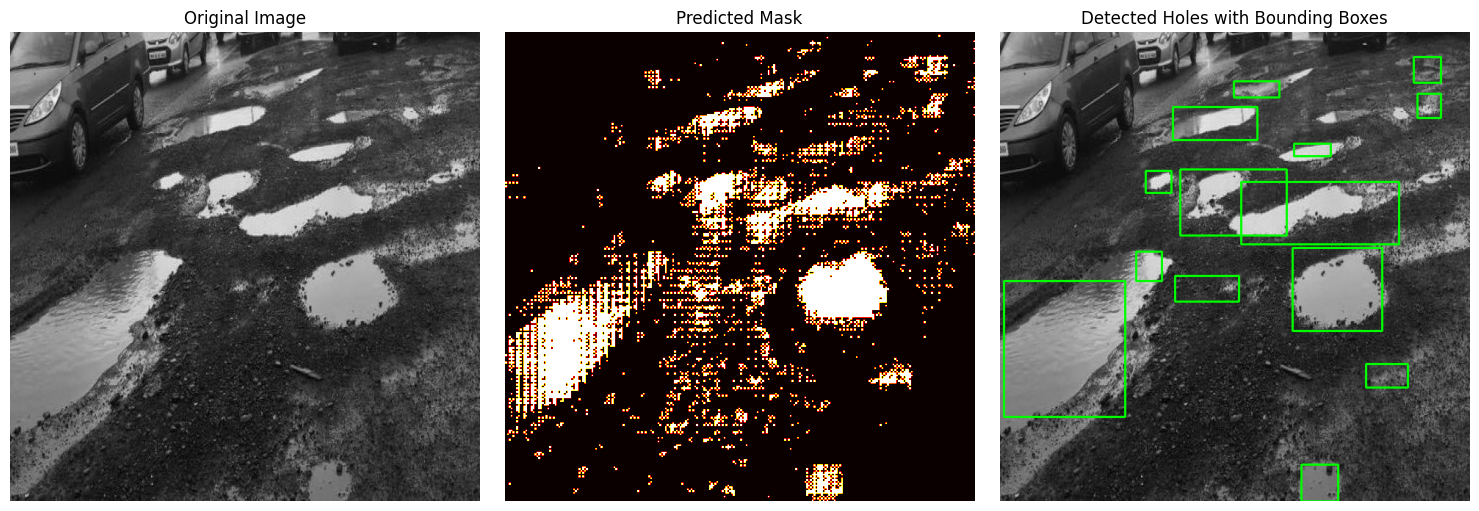

In [ ]:

model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
my_mito_model = SamModel(config=model_config)
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/Pothole Segmentation-2/50epochs_checkpoin.pth", weights_only=True))
my_mito_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_mito_model.to(device)


large_test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
large_test_image_rgb = cv2.cvtColor(large_test_image, cv2.COLOR_GRAY2RGB)
single_image = Image.fromarray(large_test_image_rgb)


# prompt
array_size = large_test_image_rgb.shape[0]
grid_size = 10
x = np.linspace(0, array_size - 1, grid_size)
y = np.linspace(0, array_size - 1, grid_size)
xv, yv = np.meshgrid(x, y)
xv_list = xv.tolist()
yv_list = yv.tolist()
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]
input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2)

#  prompt+ image for the model
inputs = processor(single_image, input_points=input_points, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}


with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# sigmoid
prob_masks = torch.sigmoid(outputs.pred_masks.squeeze(1))
prob_masks = prob_masks.cpu().numpy().squeeze()

# Convert soft masks to hard masks
pred_masks = (prob_masks > 0.85).astype(np.uint8)

# Resize predicted masks to match the dimensions of the original image
pred_masks_resized = cv2.resize(pred_masks, (large_test_image_rgb.shape[1], large_test_image_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

# Clean up the masks using morphological operations
kernel = np.ones((5, 5), np.uint8)
cleaned_mask = cv2.morphologyEx(pred_masks_resized, cv2.MORPH_CLOSE, kernel)
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)

# Find contours in the cleaned mask
contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw on for detected holes
detected_holes_image = large_test_image_rgb.copy()

# Set a minimum area threshold to filter small contours
min_contour_area = 500

for contour in contours:
    area = cv2.contourArea(contour)
    if area > min_contour_area:  # Only draw bounding boxes for larger contours
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(detected_holes_image, (x, y), (x + w, y + h), (0, 255, 0), 2)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(large_test_image_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

#  predicted mask
axes[1].imshow(pred_masks_resized, cmap='hot')
axes[1].set_title("Predicted Mask")
axes[1].axis('off')

# Detected potholes image
axes[2].imshow(cv2.cvtColor(detected_holes_image, cv2.COLOR_BGR2RGB))
axes[2].set_title("Detected Holes with Bounding Boxes")
axes[2].axis('off')

# Display the images side by side
plt.tight_layout()
plt.show()


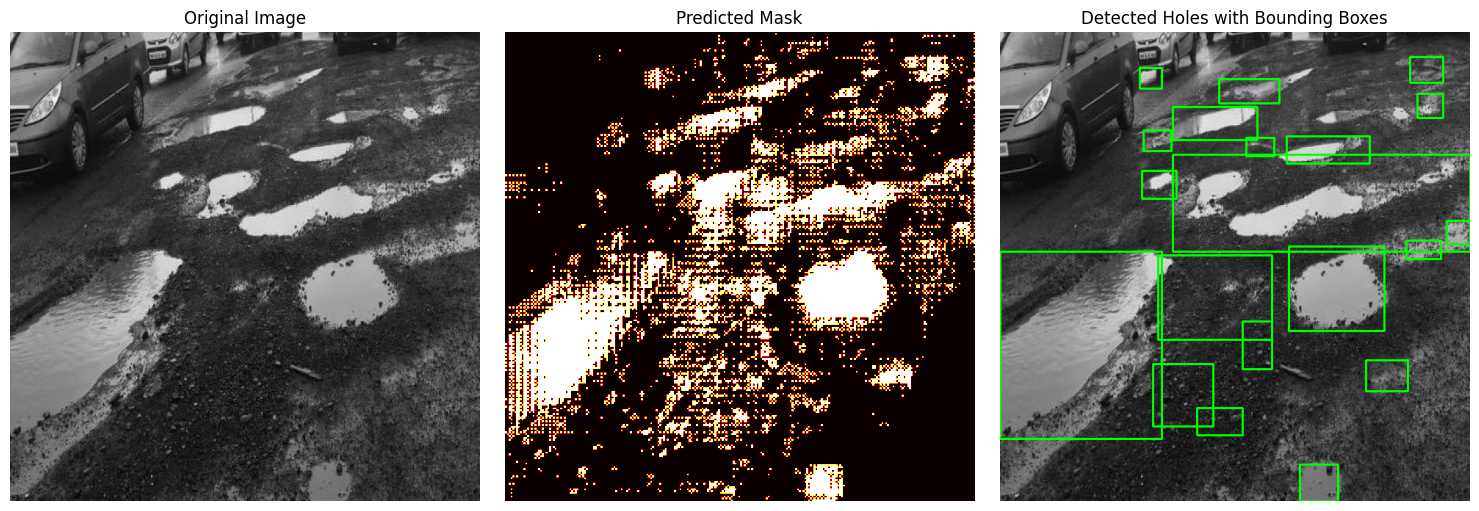

In [ ]:
# threshold change#


# Convert soft masks to hard masks
pred_masks = (prob_masks > 0.75).astype(np.uint8)

# Resize predicted masks to match the dimensions of the original image
pred_masks_resized = cv2.resize(pred_masks, (large_test_image_rgb.shape[1], large_test_image_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

# Clean up the masks using morphological operations
kernel = np.ones((5, 5), np.uint8)
cleaned_mask = cv2.morphologyEx(pred_masks_resized, cv2.MORPH_CLOSE, kernel)
cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)

# Find contours in the cleaned mask
contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a copy of the original image to draw on for detected holes
detected_holes_image = large_test_image_rgb.copy()

# Set a minimum area threshold to filter small contours
min_contour_area = 500

for contour in contours:
    area = cv2.contourArea(contour)
    if area > min_contour_area:  # Only draw bounding boxes for larger contours
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(detected_holes_image, (x, y), (x + w, y + h), (0, 255, 0), 2)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# original image
axes[0].imshow(large_test_image_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

# predicted mask
axes[1].imshow(pred_masks_resized, cmap='hot')
axes[1].set_title("Predicted Mask")
axes[1].axis('off')

#  detected holes image
axes[2].imshow(cv2.cvtColor(detected_holes_image, cv2.COLOR_BGR2RGB))
axes[2].set_title("Detected Holes with Bounding Boxes")
axes[2].axis('off')

plt.tight_layout()
plt.show()


# Video

In [ ]:
video_path = '/content/potholesinaruralroad.mp4'
output_video_path = '/content/output.avi'
mask_output_path = '/content/all_masks.npy'


cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = None

frame_idx = 0
all_masks = []
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
with tqdm(total=total_frames, desc="Processing video", unit="frame") as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB and process
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)

        # Define input points
        array_size = frame_rgb.shape[0]
        grid_size = 10
        x = np.linspace(0, array_size - 1, grid_size)
        y = np.linspace(0, array_size - 1, grid_size)
        xv, yv = np.meshgrid(x, y)
        input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv.tolist(), yv.tolist())]
        input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2).to(device)  # Move to GPU

        # Prepare inputs for the model
        inputs = processor(pil_image, input_points=input_points.cpu().numpy().tolist(), return_tensors="pt")  # Move input_points to CPU
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass to get masks
        with torch.no_grad():
            outputs = my_mito_model(**inputs, multimask_output=False)

        prob_masks = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
        pred_masks = (prob_masks > 0.9).astype(np.uint8)
        pred_masks_resized = cv2.resize(pred_masks, (frame_rgb.shape[1], frame_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

        all_masks.append(pred_masks_resized)

        # Superimpose the mask on the frame
        overlay = np.zeros_like(frame_rgb, dtype=np.float32)
        overlay[pred_masks_resized > 0] = [1, 0, 0]
        alpha = 0.5  # Opacity
        superimposed_image = np.clip(frame_rgb / 255.0 + alpha * overlay, 0, 1)

        # Convert back to BGR for video writing
        superimposed_frame_bgr = (superimposed_image * 255).astype(np.uint8)

        # Initialize the video writer once the frame size is known
        if out is None:
            frame_height, frame_width = frame.shape[:2]
            out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (frame_width, frame_height))

        # Write the frame with the superimposed mask to the video
        out.write(superimposed_frame_bgr)

        # Update progress bar
        frame_idx += 1
        pbar.update(1)

cap.release()
out.release()
all_masks_array = np.array(all_masks)
np.save(mask_output_path, all_masks_array)

print("Inference complete, video saved as output.avi, and all masks stored as a single .npy file.")


Processing video: 100%|██████████| 692/692 [05:46<00:00,  2.00frame/s]


Inference complete, video saved as output.avi, and all masks stored as a single .npy file.


In [ ]:

output_video_path = '/content/output.avi'
mp4_output_path = '/content/output2.mp4'
os.system(f'ffmpeg -i "{output_video_path}" -c:v libx264 -c:a aac "{mp4_output_path}"')


0

In [ ]:
video_path = '/content/potholesinaruralroad.mp4'
output_video_path = '/content/outputbb.avi'
mask_output_path = '/content/all_masks.npy'


cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = None

frame_idx = 0

all_masks = []
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

with tqdm(total=total_frames, desc="Processing video", unit="frame") as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to RGB and process
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)

        # Define input points (use a grid, similar to previous setup)
        array_size = frame_rgb.shape[0]  # Assuming square images
        grid_size = 10
        x = np.linspace(0, array_size - 1, grid_size)
        y = np.linspace(0, array_size - 1, grid_size)
        xv, yv = np.meshgrid(x, y)
        input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv.tolist(), yv.tolist())]
        input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2).to(device)  # Move to GPU

        # Prepare inputs for the model
        inputs = processor(pil_image, input_points=input_points.cpu().numpy().tolist(), return_tensors="pt")  # Move input_points to CPU
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass to get masks
        with torch.no_grad():
            outputs = my_mito_model(**inputs, multimask_output=False)

        # Process model output (sigmoid and binary mask)
        prob_masks = torch.sigmoid(outputs.pred_masks.squeeze(1)).cpu().numpy().squeeze()
        pred_masks = (prob_masks > 0.9).astype(np.uint8)

        # Resize predicted mask to match frame size
        pred_masks_resized = cv2.resize(pred_masks, (frame_rgb.shape[1], frame_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Append the mask to the all_masks list
        all_masks.append(pred_masks_resized)

        # Find contours in the resized mask
        contours, _ = cv2.findContours(pred_masks_resized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a copy of the original frame to draw bounding boxes
        detected_holes_image = frame.copy()

        # Set a minimum area threshold to filter small contours
        min_contour_area = 500  # Adjust this value as needed

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_contour_area:  # Only draw bounding boxes for larger contours
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(detected_holes_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Initialize the video writer once the frame size is known
        if out is None:
            frame_height, frame_width = frame.shape[:2]
            out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (frame_width, frame_height))

        # Write the frame with the bounding boxes to the video
        out.write(detected_holes_image)

        # Update progress bar
        frame_idx += 1
        pbar.update(1)

# Release resources
cap.release()
out.release()

# Convert all_masks to a NumPy array and save it
all_masks_array = np.array(all_masks)
np.save(mask_output_path, all_masks_array)

print("Inference complete, video saved as output.avi, and all masks stored as a single .npy file.")


Processing video: 100%|██████████| 692/692 [05:28<00:00,  2.11frame/s]


Inference complete, video saved as output.avi, and all masks stored as a single .npy file.


In [ ]:

output_video_path = '/content/outputbb.avi'
mp4_output_path = '/content/output2bb.mp4'
os.system(f'ffmpeg -i "{output_video_path}" -c:v libx264 -c:a aac "{mp4_output_path}"')

0